## Automatic Differentiation

This is a simple implementation of automatic differentiation in Python. It is based on the chain rule and supports both scalar and vector functions. The code is well-documented and easy to understand. We will use this implementation to derive the gradient of a scalar function $\psi(x,y)$ with respect to $x$ and $y$ in schrodinger equation to get the best potential curve for a given Hamiltonian.

In [19]:
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy as jsp
from jax.scipy.special import logsumexp
from scipy import special
import numpy as np

In [20]:
!nvidia-smi
jax.devices()

Mon Jul  7 20:20:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.81                 Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P8              2W /  121W |    2533MiB /   8188MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[CpuDevice(id=0)]

In [21]:
grad_tanh = grad(jnp.tanh)
print(grad_tanh(0.5)) # 0.41997434161402603

0.7864477


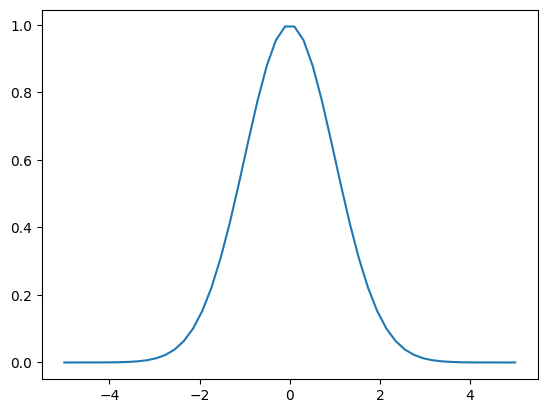

In [22]:
def wave_function(x, n):
    """
    计算n个粒子在二维空间中的波函数值
    :param x: 粒子的位置，数组，shape为(2,)
    :param n: 离散谱的能级
    :return: 波函数值，标量
    """
    p_monic = special.hermite(n, monic=True)
    psi = np.exp(-0.5 * x**2)
    return psi * p_monic(x)

num = 50
x = jnp.linspace(-5, 5, num)
real_wave_function = wave_function(x, 0)

plt.plot(x, real_wave_function)
plt.show()


## Automatic Differentiation For Potential Curve Fitting
Here we will implement automatic differentiation to fit a potential curve to theoritical data.

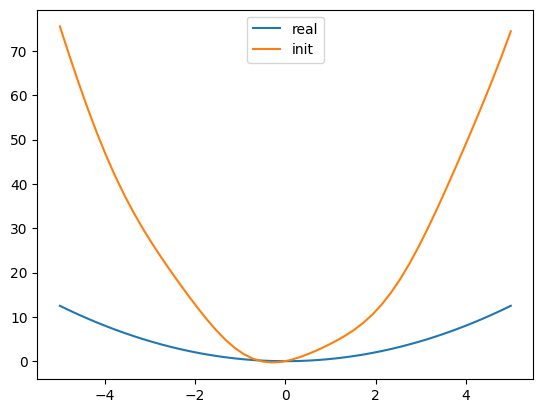

In [23]:
def v_d(a, b, c, x):
    """
    初始化势能
    :param x: 粒子的位置，数组，shape为(2,)
    :return: 势能值，标量
    """
    v = a*jnp.sin(b*x) + c*x**2
    return v
def v_real(x):
    """
    初始化势能
    :param x: 粒子的位置，数组，shape为(2,)
    :return: 势能值，标量
    """
    v_real = 1/2*x**2
    return v_real
a = 1
b = 2
c = 3
v_real = v_real(x)
v_init = v_d(a, b, c ,x)
plt.plot(x, v_real, label='real')
plt.plot(x, v_init, label='init')
plt.legend()
plt.show()

In [30]:
def Hamiltonian(a, b, c, x, num):
    H = jnp.zeros((num, num))
    v = v_d(a, b, c, x)       
    K = jnp.zeros((num, num))
    for i in range(num):
        for j in range(num):
            if i == j:
                K = K.at[i, j].set(-2)
            elif i == j + 1 or i == j - 1:
                K = K.at[i, j].set(1)
            else:
                K = K.at[i, j].set(0)
    for i in range(num):
        for j in range(num):
            H = H.at[i, j].set(K[i, j] + v[i] * (i == j))
    return H


def loss(a,b,c):
    _, eigenstate = jax.scipy.linalg.eigh(Hamiltonian(a, b, c, x, num=num))
    real = real_wave_function
    cal = eigenstate[0]
    loss = (real - cal)**2
    print(f"real={real}, cal={cal}, loss={loss}")
    return jnp.sum(loss)

def train(a, b, c, num_epochs=1000, learning_rate=0.01):
    for epoch in range(num_epochs):
        # 计算损失和梯度
        loss_value, grads = jax.value_and_grad(loss, argnums=(0, 1, 2))(a, b, c)
        
        # 更新参数
        a = -learning_rate * grads[0]
        b = -learning_rate * grads[1]
        c = -learning_rate * grads[2]
        
        # 每 100 个 epoch 打印一次损失值
        print(f"Epoch {epoch}, loss = {loss_value}")
        print(f"Epoch {epoch}, parameters: a={a}, b={b}, c={c}")
     
            
    return a, b, c
a, b, c = train(a, b, c, num_epochs=10, learning_rate=0.1)
print(f"Final parameters: a={a}, b={b}, c={c}")

_, cal = jax.scipy.linalg.eigh(Hamiltonian(a, b, c, x, num=num))

plt.plot(x, real_wave_function, label="real")
plt.plot(x, cal, label="cal")
plt.legend()
plt.show()

